# Environment:

In [ ]:
!pip install torchvision
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-h_4yz0kg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-h_4yz0kg
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=922403af1847ef2132f330c6ae3c12050a6aa423298b691e0367404e5cb1ed71
  Stored in directory: /tmp/pip-ephem-wheel-cache-dqaohqlr/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import Caltech256
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Function
import clip
import os
import shutil

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

# Model and Data Initialization:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 107MiB/s]


In [ ]:
data_dir = '/caltech256'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Loading dataset
caltech256 = Caltech256(root=data_dir, download=True, transform=preprocess)
dataloader = DataLoader(caltech256, shuffle=False)

Downloading...
From (original): https://drive.google.com/uc?id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK
From (redirected): https://drive.usercontent.google.com/download?id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK&confirm=t&uuid=bbd04172-a74c-4cf6-84f0-318bbc88fd5e
To: /caltech256/caltech256/256_ObjectCategories.tar
100%|██████████| 1.18G/1.18G [00:36<00:00, 32.5MB/s]


Extracting /caltech256/caltech256/256_ObjectCategories.tar to /caltech256/caltech256


# Encoding image into vectors with CLIP:

In [ ]:
def encode_images(model, dataloader, device):
    all_features = []
    all_labels = []

    for images, labels in dataloader:
        images = images.to(device)

        # Encode images using CLIP
        with torch.no_grad():
            image_features = model.encode_image(images)

        # Store the vector representation
        all_features.append(image_features.cpu())
        all_labels.append(labels)

    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)

    return all_features, all_labels

In [ ]:
start_time = time.time()
encoded_features, labels = encode_images(model, dataloader, device)
end_time = time.time()
elapsed_time = end_time - start_time

print("Time Taken:", elapsed_time)
print("Encoded Features Shape:", encoded_features.shape)
print("Labels Shape:", labels.shape)

Time Taken: 415.64593267440796
Encoded Features Shape: torch.Size([30607, 512])
Labels Shape: torch.Size([30607])


In [ ]:
encoded_features_np = encoded_features.cpu().numpy()
df_encoded_features = pd.DataFrame(encoded_features_np)
df_encoded_features.to_csv('encoded_features.csv', index=False)

## Sample Image and its vector representation:

In [ ]:
def show_image(image_tensor):
    image = image_tensor.squeeze(0)
    image = image.permute(1, 2, 0).cpu().numpy()  # Dimensions (C, H, W) -> (H, W, C)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

First image in the dataset:


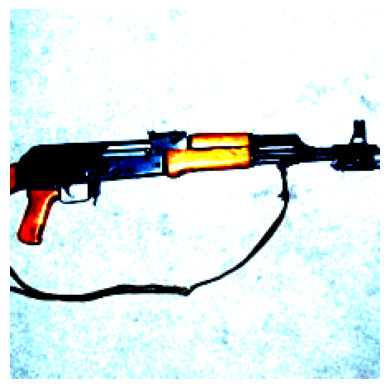


CLIP vector representation of the first image:
[[ 9.0454e-02  1.3220e-01  2.4307e-02 -2.9736e-01 -1.4050e-01 -1.8848e-01
   1.7615e-01 -8.0994e-02 -2.1533e-01  3.6743e-02  2.2388e-01 -2.5757e-01
   3.0322e-01 -2.1521e-01  2.3511e-01 -1.5845e-01  1.6094e+00  3.9478e-01
  -3.0933e-01 -3.2129e-01 -6.5765e-03 -2.9883e-01  2.4353e-01 -2.6025e-01
  -2.3499e-01  1.7175e-01  1.8054e-01 -3.2288e-02 -3.4814e-01 -8.2153e-02
  -1.2598e-01  4.1040e-01  5.8838e-02 -1.2952e-01 -2.4268e-01 -1.6663e-01
   1.5393e-01  2.0782e-02 -3.3325e-01  1.1602e+00 -2.4548e-01 -3.9551e-01
   4.9072e-01 -5.0342e-01  4.5776e-01  1.5801e+00  4.4263e-01 -4.0985e-02
  -3.9111e-01 -2.9175e-01  3.9990e-01 -2.1802e-01 -1.9531e-01 -4.0601e-01
  -9.7473e-02 -9.0332e-02 -2.5208e-02  4.0649e-01  3.8867e-01  3.1201e-01
   1.6272e-01 -1.7773e-01  1.0870e-01  5.6689e-01  4.5380e-02  3.6743e-01
   5.8807e-02 -2.2498e-01 -1.3037e-01 -1.6089e-01 -1.6394e-01  2.5952e-01
  -1.9116e-01  2.0911e-01 -2.9346e-01  2.6318e-01  7.9285e-02 -5

In [ ]:
# Get the first image and label from the dataloader
first_image, first_label = next(iter(dataloader))  # Directly unpack the first batch

# Convert the label to integer
first_label = first_label.item()

# Accessing the class names from the dataset within the dataloader
class_names = dataloader.dataset.categories  # Caltech256 uses 'categories'

print("First image in the dataset:")
show_image(first_image)  # Function to display the image

# Move the image to the device
first_image = first_image.to(device)

with torch.no_grad():
    first_image_features = model.encode_image(first_image)

# Retrieve the class name corresponding to the label
first_image_class = class_names[first_label]  # Mapping label to class name

print("\nCLIP vector representation of the first image:")
print(first_image_features.cpu().numpy())

print("\nClass label of the first image: ", first_image_class)

# Content Based Image Retrieval:

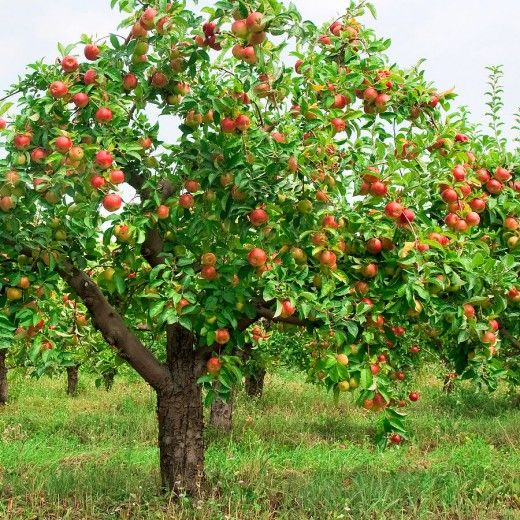

In [ ]:
img = Image.open("/content/fruit_tree.jpg").convert("RGB")
img

## Encoding:

In [ ]:
img = preprocess(img).unsqueeze(0).to(device)  # Preprocess and add a batch dimension

with torch.no_grad():
    uploaded_image_features = model.encode_image(img)

## Similarity:

In [ ]:
similarities = cosine_similarity(uploaded_image_features.cpu(), encoded_features.cpu())
top_k_indices = similarities[0].argsort()[-10:][::-1]
top_k_indices

array([29803, 24866, 24832, 24893,  9927,  9879, 24874,  9876,  9843,
       24819])

In [ ]:
def display_similar_images(top_indices, dataset, labels):

    num_images = len(top_indices)
    plt.figure(figsize=(num_images * 2, 5))

    for i, idx in enumerate(top_indices):
        image, label = dataset[idx]
        plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
        plt.imshow(image.permute(1, 2, 0))  # Permute the image for display (C, H, W) -> (H, W, C)
        plt.title(f"Category: {caltech256.categories[labels[idx]]}")
        plt.axis('off')  # Turn off axis ticks/labels

    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()


Top 10 similar images to the uploaded image:


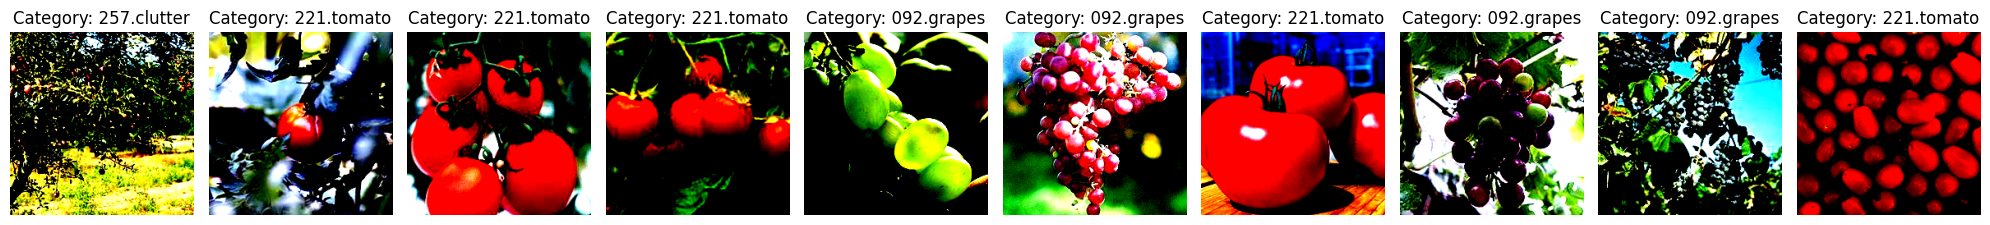

In [ ]:
print("\nTop 10 similar images to the uploaded image:")
display_similar_images(top_k_indices, dataloader.dataset, labels)

In [ ]:
def save_image_from_dataloader(dataloader, index, image_name):
    """
    Save an image from the dataloader at the specified index.

    Parameters:
    - dataloader: The dataloader object.
    - index: The index of the image to save.
    - image_name: The name of the file to save the image as.
    """
    # Get the image tensor from the dataset
    image_tensor = dataloader.dataset[index][0]

    # Permute the tensor from (C, H, W) to (H, W, C)
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Move to CPU and convert to NumPy array

    # Clamp the values to ensure they are in the range [0, 1] if they are not already
    image_np = np.clip(image_np, 0, 1)

    # Convert to uint8
    image_np = (image_np * 255).astype(np.uint8)

    # Save the image using plt.imsave
    plt.imsave(os.path.join(directory_path, image_name), image_np)

In [ ]:
directory_path = 'content/retrieved_images'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

for i in range(5):
    image_name = f"retrieved_{i + 1}.jpg"
    save_image_from_dataloader(dataloader, top_k_indices[i], image_name)

# CBIR Performace Evaluation:

Select 100 random indices

In [ ]:
random_indices = np.array([24583, 19039,  4831,  9273, 16800, 29076,  5022, 10268,  5936, 11362,  8232, 21388,  6053, 20966,  7731, 12956, 22771, 27212,
        6797,  7110, 24865,  2662, 16726, 25256, 24165,  3960, 12744, 1169, 10266, 17923, 19470, 16169,  3034,  8732, 18930, 13307,
       26230, 14472, 22488,  6360, 27823, 14078, 16026, 21599, 24334, 3582,   587, 23039, 15661, 22622,  6187, 27708, 20197, 24533,
       20833, 25945, 20525, 11697,  4274, 19717, 20440, 12930, 15839, 23285, 10379, 10589, 20980, 26897, 25352,  4007, 23378,  5837,
       30185, 14356, 18739, 12763, 19624, 14882, 13132,  2371, 15923, 12845, 29844,  9133,  3562, 30552, 20459, 23611, 24642, 24000,
        3460, 13625, 29261, 17575, 28474, 14462, 26141, 22206, 18451, 3673])
random_indices

array([24583, 19039,  4831,  9273, 16800, 29076,  5022, 10268,  5936,
       11362,  8232, 21388,  6053, 20966,  7731, 12956, 22771, 27212,
        6797,  7110, 24865,  2662, 16726, 25256, 24165,  3960, 12744,
        1169, 10266, 17923, 19470, 16169,  3034,  8732, 18930, 13307,
       26230, 14472, 22488,  6360, 27823, 14078, 16026, 21599, 24334,
        3582,   587, 23039, 15661, 22622,  6187, 27708, 20197, 24533,
       20833, 25945, 20525, 11697,  4274, 19717, 20440, 12930, 15839,
       23285, 10379, 10589, 20980, 26897, 25352,  4007, 23378,  5837,
       30185, 14356, 18739, 12763, 19624, 14882, 13132,  2371, 15923,
       12845, 29844,  9133,  3562, 30552, 20459, 23611, 24642, 24000,
        3460, 13625, 29261, 17575, 28474, 14462, 26141, 22206, 18451,
        3673])

Define function that returns accuracy of each retrieval

In [ ]:
import warnings
from torchvision.utils import save_image
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.image')

In [ ]:
def retrieve_similar_images(query_index, encoded_features, dataloader, labels, k=10, save_path="content/retrieved_images/"):
    """
    Retrieve, print, and save the top-k similar images based on cosine similarity, along with their labels.
    Returns a score indicating how many retrieved images share the same label as the query image.
    Also creates a DataFrame of the query image similarities.

    Args:
    - query_index (int): Index of the query image in the dataset.
    - encoded_features (torch.Tensor): Encoded features of all images in the dataset.
    - dataloader (torch.utils.data.DataLoader): Dataloader containing the dataset images.
    - labels (list): List of labels corresponding to the dataset images.
    - k (int): Number of similar images to retrieve (default is 10).
    - save_path (str): Path to save the retrieved images.

    Returns:
    - score (int): Number of retrieved images with the same label as the query image.
    - query_similarities (DataFrame): DataFrame containing similarities with all images.
    """

    dataset = dataloader.dataset

    # Convert encoded features to numpy if it's a tensor
    encoded_features_np = encoded_features.cpu().numpy() if isinstance(encoded_features, torch.Tensor) else encoded_features

    # Step 1: Extract the query image feature vector
    query_feature = encoded_features_np[query_index].reshape(1, -1)

    # Step 2: Compute cosine similarities between the query feature and all other features
    similarities = cosine_similarity(query_feature, encoded_features_np).flatten()

    # Step 3: Get the indices of the top-k most similar images (excluding the query image itself)
    top_k_indices = similarities.argsort()[-(k + 1):][::-1]  # Get k+1 to include the query image itself

    # Step 4: Create a folder to save the images
    query_folder = os.path.join(save_path, str(query_index + 1))
    os.makedirs(query_folder, exist_ok=True)

    # Step 5: Display the query image and the top-k similar images
    query_image, _ = dataset[query_index]  # Extract the query image from the dataset

    score = 0

    # Plot the query image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, k + 1, 1)
    plt.imshow(query_image.permute(1, 2, 0))  # Change dimensions to HxWxC for plotting
    plt.title(f'Query Image\nLabel: {labels[query_index]}')
    plt.axis('off')

    # Initialize a list to store similarity data for the DataFrame
    similarity_data = []

    for i, idx in enumerate(top_k_indices[1:k + 1]):  # Skip the first one as it is the query image itself
        similar_image, _ = dataset[idx]  # Get the similar image
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(similar_image.permute(1, 2, 0))  # Change dimensions to HxWxC for plotting
        plt.title(f"Rank {i + 1}\nLabel: {labels[idx]}")
        plt.axis('off')

        # Check if the label matches the query label
        if labels[idx] == labels[query_index]:
            score += 1

    # Create a similarity row for the DataFrame
    similarity_row = {
        'Query Image Index': query_index,
    }

    # Add similarity scores to the dictionary
    for idx, sim_score in enumerate(similarities):
        similarity_row[f'similarity_with_image_{idx + 1}'] = sim_score

    # Append the row to the similarity data list
    similarity_data.append(similarity_row)

    # Convert similarity data to DataFrame
    query_similarities = pd.DataFrame(similarity_data)

    # Save the DataFrame to CSV
    query_similarities.to_csv('/content/query_similarities.csv', index=False)

    plt.show()

    return score, query_similarities

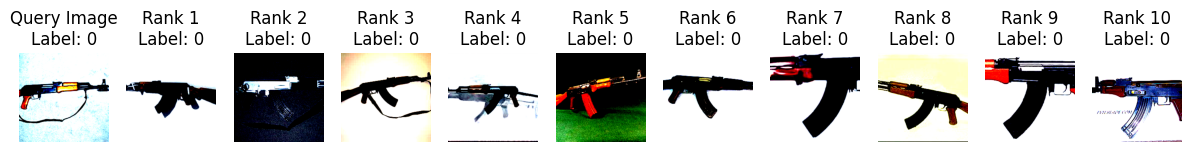

(0.5495953038683554,
    Query Image Index  similarity_with_image_1  similarity_with_image_2  \
 0                  0                      1.0                 0.891629   
 
    similarity_with_image_3  similarity_with_image_4  similarity_with_image_5  \
 0                 0.894698                  0.70541                 0.662831   
 
    similarity_with_image_6  similarity_with_image_7  similarity_with_image_8  \
 0                 0.792363                 0.932603                 0.530962   
 
    similarity_with_image_9  ...  similarity_with_image_30598  \
 0                 0.909983  ...                     0.565193   
 
    similarity_with_image_30599  similarity_with_image_30600  \
 0                     0.588914                     0.588017   
 
    similarity_with_image_30601  similarity_with_image_30602  \
 0                     0.526904                     0.492569   
 
    similarity_with_image_30603  similarity_with_image_30604  \
 0                     0.425248            

In [ ]:
retrieve_similar_images(query_index=0, encoded_features=encoded_features, dataloader=dataloader, labels=labels, k=10)

Average it over all indices over random_indices

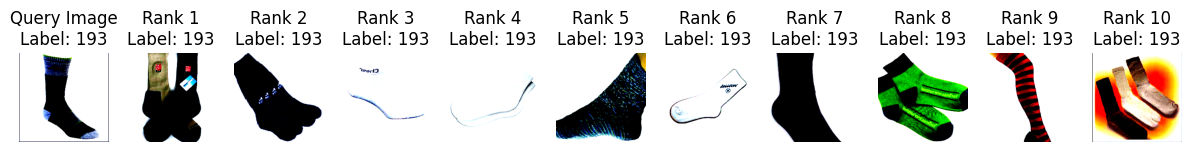

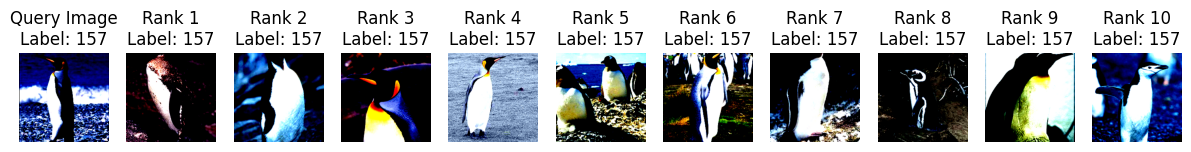

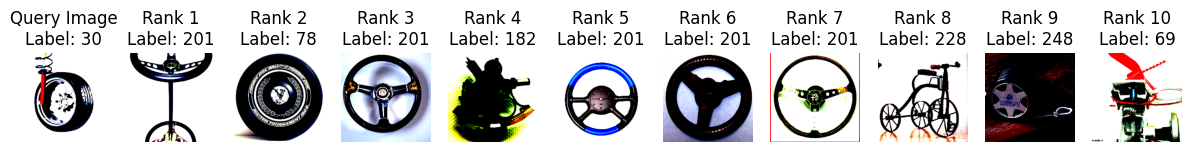

Accuracies for each query image: [10  0  7 10 10 10  8 10 10 10 10 10 10  9 10 10  7 10 10  8 10 10 10 10
 10 10  9 10 10  3 10 10 10 10 10 10 10 10  2  2  2 10 10 10 10  9 10  5
 10  5 10 10 10 10 10 10 10  8 10  9 10  9  0 10 10 10  7  1  3  6  8 10
 10 10  2  3 10  0  9 10  2 10 10 10  1 10 10  1  8 10  1  7 10 10 10  2
 10 10 10  0]


In [ ]:
accuracies = []
query_similarities_list = []

for i, index in enumerate(random_indices):
    score, query_similarity = retrieve_similar_images(query_index=index, encoded_features=encoded_features, dataloader=dataloader, labels=labels, k=10)
    accuracies.append(score)
    query_similarities_list.append(query_similarity)

query_similarities = pd.concat(query_similarities_list, ignore_index=True)
query_similarities.to_csv('/content/query_similarities.csv', index=False)

accuracies_array = np.array(accuracies)
print("Accuracies for each query image:", accuracies_array)

Outputs of the previous cell were cleared, to save notebook storage space. Above is a sample of few retrievals.

In [ ]:
np.mean(accuracies_array)

8.13

# Explainability Model:

## Generating Image Caption:

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
def generate_caption(image_path):
    image = Image.open(image_path)
    inputs = processor(image, return_tensors="pt")
    with torch.no_grad():
        out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [ ]:
caption = generate_caption('/content/fruit_tree.jpg')
print("Generated Caption:", caption)

Generated Caption: a large tree with lots of apples growing on it


## Captions for 100 query images

In [ ]:
def generate_caption_from_tensor(image_tensor):
    image_pil = transforms.ToPILImage()(image_tensor)
    inputs = processor(image_pil, return_tensors="pt")
    with torch.no_grad():
        out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [ ]:
query_captions = []

for query_index in random_indices:
    query_image, _ = dataloader.dataset[query_index]
    caption = generate_caption_from_tensor(query_image)
    query_captions.append(caption)

In [ ]:
for i, caption in enumerate(query_captions):
    print(f"Caption for query image {random_indices[i]}: {caption}")

Caption for query image 24583: a tennis racket with a red background
Caption for query image 19039: a car is painted red and blue
Caption for query image 4831: a colorful picture of a man on a surfboard
Caption for query image 9273: a digital image of a man's face
Caption for query image 16800: a motorcycle is shown in a colorful picture
Caption for query image 29076: a man with a beard
Caption for query image 5022: a large, green, circular object with a blue center
Caption for query image 10268: a cup of coffee
Caption for query image 5936: a red background with a blue and yellow globe
Caption for query image 11362: a man with a beard
Caption for query image 8232: a picture of a television set with a television screen
Caption for query image 21388: a red and blue sky
Caption for query image 6053: a map of the world with a red and green area
Caption for query image 20966: a colorful flower with many colors
Caption for query image 7731: a fire hydrant
Caption for query image 12956: a fi

## Image-Text CLIP Explanation:

### Functions:

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1477 (delta 90), reused 85 (delta 85), pack-reused 1324 (from 1)
Receiving objects: 100% (1477/1477), 25.57 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (578/578), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00


In [ ]:
import CLIP.clip as clip
import cv2
from captum.attr import visualization

In [ ]:
def interpret(image, texts, model, device, start_layer=-1, start_layer_text=-1):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [ ]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [ ]:
def visualize_heatmap(image_path, caption, model, device):
    img = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    texts = [caption]
    text = clip.tokenize(texts).to(device)
    R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
    batch_size = text.shape[0]
    for i in range(batch_size):
        show_heatmap_on_text(texts[i], text[i], R_text[i])
        show_image_relevance(R_image[i], img, orig_image=Image.open(image_path))
        plt.show()

### Execution:

tensor([0.0323, 0.3267, 0.3416, 0.1555, 0.0251, 0.0292, 0.0292, 0.0031, 0.0575],
       device='cuda:0', dtype=torch.float16)


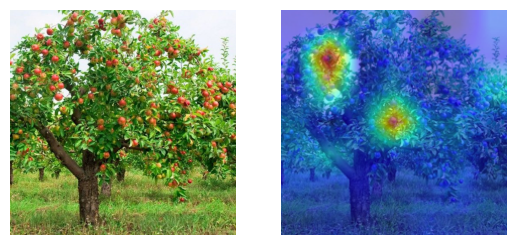

In [ ]:
path = '/content/fruit_tree.jpg'
visualize_heatmap(path, caption, model, device)

Processing image: /content/content/retrieved_images/10267/retrieved_1.png
tensor([0.0267, 0.0538, 0.1385, 0.1115, 0.0624, 0.1183, 0.2369, 0.0308, 0.2208],
       device='cuda:0', dtype=torch.float16)


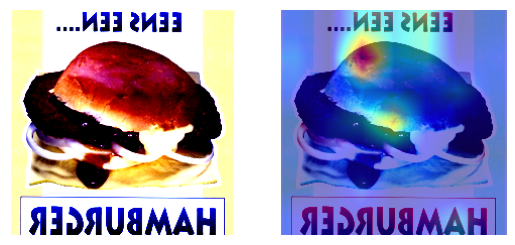

Processing image: /content/content/retrieved_images/10267/retrieved_4.png
tensor([0.0064, 0.1027, 0.4912, 0.1499, 0.0133, 0.0284, 0.0969, 0.0286, 0.0826],
       device='cuda:0', dtype=torch.float16)


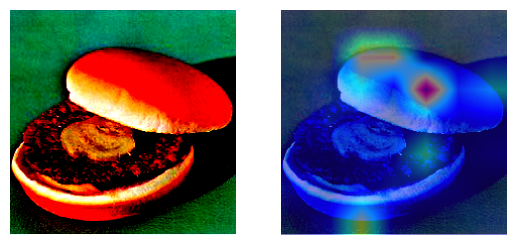

Processing image: /content/content/retrieved_images/10267/retrieved_8.png
tensor([0.0237, 0.0444, 0.2837, 0.0311, 0.0181, 0.1151, 0.1487, 0.0342, 0.3013],
       device='cuda:0', dtype=torch.float16)


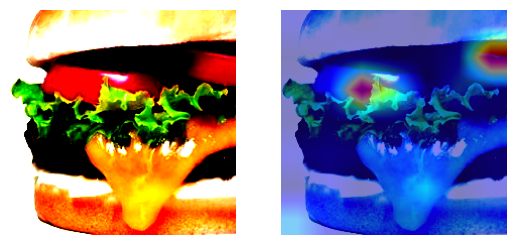

Processing image: /content/content/retrieved_images/10267/retrieved_3.png
tensor([0.0735, 0.2705, 0.2627, 0.0384, 0.0119, 0.0185, 0.1698, 0.0376, 0.1172],
       device='cuda:0', dtype=torch.float16)


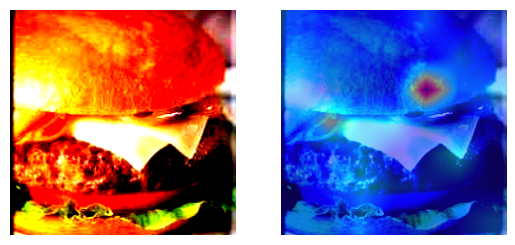

Processing image: /content/content/retrieved_images/10267/query_image.png
tensor([0.1349, 0.1558, 0.2101, 0.0721, 0.0270, 0.2769, 0.0906, 0.0326, 0.0000],
       device='cuda:0', dtype=torch.float16)


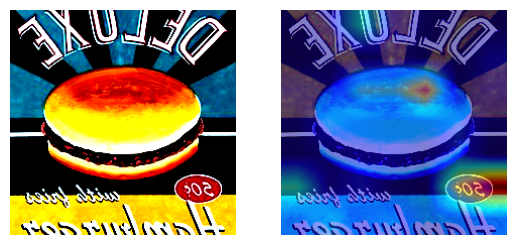

Processing image: /content/content/retrieved_images/10267/retrieved_6.png
tensor([0.0143, 0.0305, 0.3083, 0.2250, 0.0803, 0.0963, 0.1704, 0.0222, 0.0524],
       device='cuda:0', dtype=torch.float16)


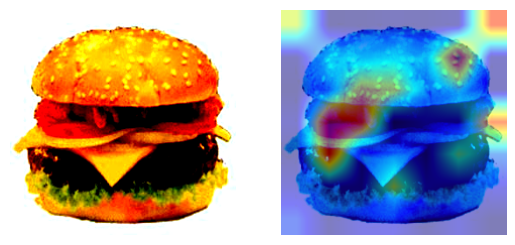

Processing image: /content/content/retrieved_images/10267/retrieved_5.png
tensor([0.1249, 0.4749, 0.2000, 0.0105, 0.0112, 0.0127, 0.0465, 0.0101, 0.1096],
       device='cuda:0', dtype=torch.float16)


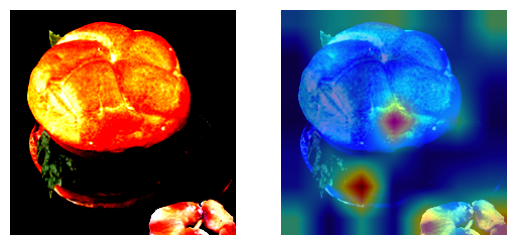

Processing image: /content/content/retrieved_images/10267/retrieved_2.png
tensor([0.0406, 0.2169, 0.3130, 0.0339, 0.0452, 0.0826, 0.1530, 0.0228, 0.0919],
       device='cuda:0', dtype=torch.float16)


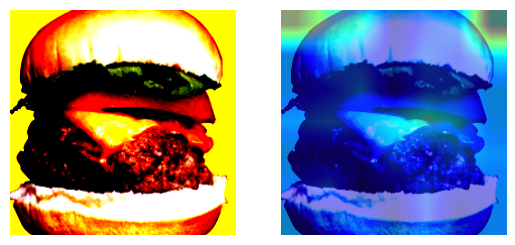

Processing image: /content/content/retrieved_images/10267/retrieved_7.png
tensor([0.0662, 0.1791, 0.1747, 0.0547, 0.0064, 0.0593, 0.2917, 0.0707, 0.0975],
       device='cuda:0', dtype=torch.float16)


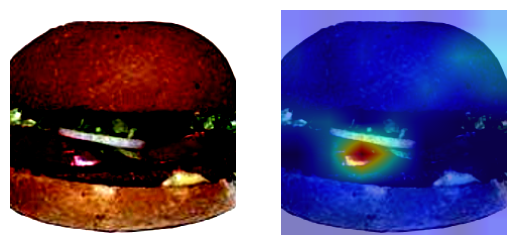

Processing image: /content/content/retrieved_images/10267/retrieved_9.png
tensor([0.0151, 0.0769, 0.4255, 0.1656, 0.0399, 0.0399, 0.1334, 0.0239, 0.0795],
       device='cuda:0', dtype=torch.float16)


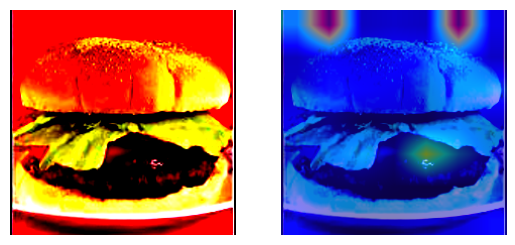

Processing image: /content/content/retrieved_images/10267/retrieved_10.png
tensor([3.9387e-04, 5.2765e-02, 5.3809e-01, 4.6051e-02, 1.1339e-03, 1.0406e-01,
        4.5349e-02, 8.4686e-03, 2.0361e-01], device='cuda:0',
       dtype=torch.float16)


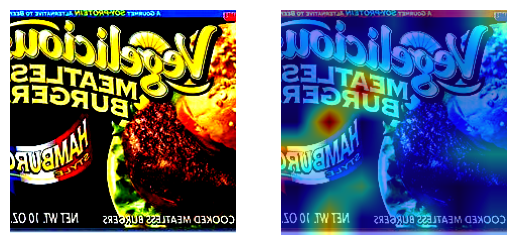

In [ ]:
folder_path = "/content/content/retrieved_images/10267"
for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"Processing image: {img_path}")
        visualize_heatmap(img_path, caption, model, device)

# xAI Model Evaluation:

## Relevant parts of Image:

In [ ]:
img = preprocess(Image.open('/content/fruit_tree.jpg')).unsqueeze(0).to(device)
texts = [caption]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

In [ ]:
type(img)

torch.Tensor

In [ ]:
R_text.shape, R_image.shape

(torch.Size([1, 77, 77]), torch.Size([1, 49]))

In [ ]:
R_image

tensor([[0.0023, 0.0019, 0.0044, 0.0055, 0.0006, 0.0009, 0.0045, 0.0032, 0.0207,
         0.0015, 0.0031, 0.0026, 0.0038, 0.0034, 0.0023, 0.0117, 0.0030, 0.0059,
         0.0010, 0.0014, 0.0078, 0.0054, 0.0007, 0.0040, 0.0173, 0.0054, 0.0052,
         0.0025, 0.0044, 0.0075, 0.0034, 0.0032, 0.0036, 0.0041, 0.0019, 0.0025,
         0.0017, 0.0030, 0.0012, 0.0018, 0.0037, 0.0015, 0.0006, 0.0018, 0.0011,
         0.0005, 0.0028, 0.0018, 0.0014]], device='cuda:0',
       dtype=torch.float16)

## Perturbation:

### Function:

In [ ]:
def perturb_image(image, image_relevance, percentage_to_remove=0.2, method='zero'):
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=image.shape[2:], mode='bilinear')
    image_relevance = image_relevance.squeeze().cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    flattened_relevance = image_relevance.flatten()
    threshold = np.percentile(flattened_relevance, 100 - (percentage_to_remove * 100))
    mask = (image_relevance >= threshold).astype(np.uint8)

    image_np = image[0].permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    if method == 'zero':
        image_np[mask == 1] = 0
    elif method == 'blur':
        blurred_image = cv2.GaussianBlur(image_np, (21, 21), 0)
        image_np[mask == 1] = blurred_image[mask == 1]

    perturbed_image = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).to(image.device)
    return perturbed_image

In [ ]:
perturbed_image = perturb_image(img, R_image, percentage_to_remove=0.2, method='zero')
perturbed_image

tensor([[[[0.8860, 0.8822, 0.8785,  ..., 0.9008, 0.9008, 0.9008],
          [0.8785, 0.8785, 0.8822,  ..., 0.9008, 0.9008, 0.9008],
          [0.8785, 0.8785, 0.8748,  ..., 0.9045, 0.9045, 0.9045],
          ...,
          [0.7377, 0.5783, 0.5301,  ..., 0.6153, 0.6228, 0.6524],
          [0.5153, 0.6042, 0.6672,  ..., 0.5338, 0.6302, 0.5894],
          [0.5078, 0.5523, 0.6821,  ..., 0.4930, 0.5931, 0.5635]],

         [[0.9400, 0.9362, 0.9324,  ..., 0.9515, 0.9515, 0.9515],
          [0.9324, 0.9324, 0.9362,  ..., 0.9515, 0.9515, 0.9515],
          [0.9324, 0.9324, 0.9286,  ..., 0.9515, 0.9515, 0.9515],
          ...,
          [0.7571, 0.6123, 0.5552,  ..., 0.6657, 0.6542, 0.6657],
          [0.5056, 0.6199, 0.6847,  ..., 0.5894, 0.6771, 0.6352],
          [0.4789, 0.5513, 0.6923,  ..., 0.5513, 0.6542, 0.6390]],

         [[0.9711, 0.9675, 0.9675,  ..., 1.0000, 1.0000, 1.0000],
          [0.9639, 0.9675, 0.9711,  ..., 1.0000, 1.0000, 1.0000],
          [0.9675, 0.9675, 0.9675,  ..., 0

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor.detach().cpu()
    tensor = tensor.squeeze(0)
    img_np = tensor.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    img_np = np.uint8(255 * img_np)
    return img_np

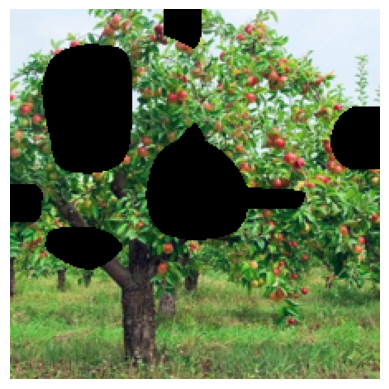

In [ ]:
img_np = tensor_to_image(perturbed_image)
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [ ]:
def interpret_and_perturb(image_path, model, device, caption, output_folder):
    # Load query image and preprocess it
    img = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    texts = [caption]
    text = clip.tokenize(texts).to(device)

    # Generate image relevance
    R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

    # Perturb the image
    perturbed_image = perturb_image(img, R_image, percentage_to_remove=0.2, method='zero')

    # Save the perturbed image
    perturbed_image_np = perturbed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    perturbed_image_np = (perturbed_image_np * 255).astype(np.uint8)
    perturbed_image_pil = Image.fromarray(perturbed_image_np)
    perturbed_image_pil.save(output_folder)

### Perturbing 100 Query Images:

In [ ]:
retrieved_folder = '/content/content/retrieved_images'
perturbed_folder = '/content/perturbed_query_images'

if not os.path.exists(perturbed_folder):
    os.makedirs(perturbed_folder)

In [ ]:
random_indices

array([24583, 19039,  4831,  9273, 16800, 29076,  5022, 10268,  5936,
       11362,  8232, 21388,  6053, 20966,  7731, 12956, 22771, 27212,
        6797,  7110, 24865,  2662, 16726, 25256, 24165,  3960, 12744,
        1169, 10266, 17923, 19470, 16169,  3034,  8732, 18930, 13307,
       26230, 14472, 22488,  6360, 27823, 14078, 16026, 21599, 24334,
        3582,   587, 23039, 15661, 22622,  6187, 27708, 20197, 24533,
       20833, 25945, 20525, 11697,  4274, 19717, 20440, 12930, 15839,
       23285, 10379, 10589, 20980, 26897, 25352,  4007, 23378,  5837,
       30185, 14356, 18739, 12763, 19624, 14882, 13132,  2371, 15923,
       12845, 29844,  9133,  3562, 30552, 20459, 23611, 24642, 24000,
        3460, 13625, 29261, 17575, 28474, 14462, 26141, 22206, 18451,
        3673])

In [ ]:
for i in range(100):  # Loop from 0 to 99 since random_indices is zero-indexed
    query_folder = os.path.join(retrieved_folder, str(random_indices[i] + 1))  # +1 to match your previous indexing
    query_image_path = os.path.join(query_folder, 'query_image.png')
    caption = query_captions[i]  # No need for -1 since i starts from 0

    # Use the random index directly for folder naming
    output_query_folder = os.path.join(perturbed_folder, str(random_indices[i] + 1))  # +1 to match your previous indexing
    if not os.path.exists(output_query_folder):
        os.makedirs(output_query_folder)

    output_image_path = os.path.join(output_query_folder, 'perturbed_query_image.png')

    interpret_and_perturb(query_image_path, model, device, caption, output_image_path)

## New Retrieval based on Perturbed Image:

In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device)

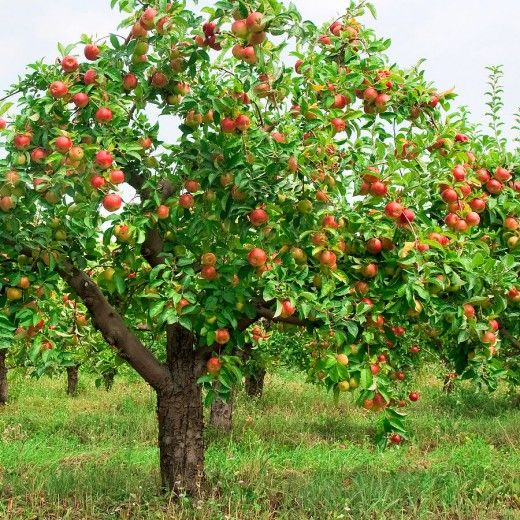

In [ ]:
img = Image.open("/content/fruit_tree.jpg").convert("RGB")
img

In [ ]:
img = preprocess(img).unsqueeze(0).to(device)

with torch.no_grad():
    uploaded_image_features = model.encode_image(img)

In [ ]:
similarities = cosine_similarity(uploaded_image_features.cpu(), encoded_features.cpu())
top_k_indices = similarities[0].argsort()[-10:][::-1]
top_k_indices

array([29803, 24866, 24832, 24893,  9927,  9879, 24874,  9876,  9843,
       24819])

In [ ]:
# Folder containing the perturbed images
perturbed_folder = '/content/perturbed_query_images'

# Initialize a list to store similarity data
similarity_data = []

# Loop through each subfolder in the perturbed images folder
for folder_name in os.listdir(perturbed_folder):
    folder_path = os.path.join(perturbed_folder, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Load the perturbed image
        img_path = os.path.join(folder_path, 'perturbed_query_image.png')
        img = Image.open(img_path).convert("RGB")
        img = preprocess(img).unsqueeze(0).to(device)

        # Encode the image and compute similarities
        with torch.no_grad():
            uploaded_image_features = model.encode_image(img)
        similarities = cosine_similarity(uploaded_image_features.cpu(), encoded_features.cpu())

        similarity_row = {
            'Query Image Index': folder_name,  # Use the folder name as the index
        }

        # Add similarity scores to the dictionary
        for idx, score in enumerate(similarities[0]):
            similarity_row[f'similarity_with_image_{idx + 1}'] = score

        # Append the row to the similarity data list
        similarity_data.append(similarity_row)

# Create a DataFrame from the list
perturbed_similarities = pd.DataFrame(similarity_data)

# Display the DataFrame
print(perturbed_similarities)

# Optionally, save the DataFrame to a CSV file
perturbed_similarities.to_csv('/content/perturbed_similarities.csv', index=False)

A dataframe of each perturbed query image with its cosine similarity with each dataset image (cos_perturbed) is saved

This can be compared to the cos_query dataframe to understand the impact of perturbation and hence the performance of saliency maps generated by TIRE

## cos_query VS cos_perturbed

query_similarities and perturbed_similarities have been initialised again from the downloaded csv files as the colab session had to be restarted. This enabled freeing space, and switching to CPU back from the T4 GPU for comparing cosine values

### Getting Data Ready

In [4]:
perturbed_similarities = pd.read_csv("/content/perturbed_similarities (1).csv")
query_similarities = pd.read_csv("/content/query_similarities (1).csv")

In [5]:
perturbed_similarities.shape == query_similarities.shape

True

In [6]:
perturbed_similarities.head()

Query Image Index  similarity_with_image_1  similarity_with_image_2  \
0               5838                 0.608698                 0.596751   
1              21600                 0.581620                 0.574735   
2              23040                 0.545222                 0.531291   
3               4008                 0.560566                 0.567584   
4               5937                 0.580880                 0.582978   

   similarity_with_image_3  similarity_with_image_4  similarity_with_image_5  \
0                 0.601987                 0.610932                 0.680792   
1                 0.588698                 0.632460                 0.731038   
2                 0.561480                 0.575456                 0.659252   
3                 0.585647                 0.592794                 0.673841   
4                 0.586905                 0.586037                 0.625536   

   similarity_with_image_6  similarity_with_image_7  similarity_with_image_8  \
0                 0.590859                 0.573569                 0.448576   
1                 0.581319                 0.554206                 0.453623   
2                 0.537561                 0.554508                 0.356433   
3                 0.580925                 0.552702                 0.425025   
4                 0.649245                 0.597002                 0.412432   

   similarity_with_image_9  ...  similarity_with_image_30598  \
0                 0.546507  ...                     0.614212   
1                 0.531278  ...                     0.641905   
2                 0.481744  ...                     0.566943   
3                 0.512447  ...                     0.599035   
4                 0.537524  ...                     0.586198   

   similarity_with_image_30599  similarity_with_image_30600  \
0                     0.750422                     0.679322   
1                     0.765459                     0.695139   
2                     0.654228                     0.592247   
3                     0.705318                     0.628350   
4                     0.658436                     0.597159   

   similarity_with_image_30601  similarity_with_image_30602  \
0                     0.697491                     0.687700   
1                     0.741873                     0.719908   
2                     0.620173                     0.624774   
3                     0.672929                     0.675664   
4                     0.618393                     0.600419   

   similarity_with_image_30603  similarity_with_image_30604  \
0                     0.618915                     0.595541   
1                     0.584011                     0.649412   
2                     0.484968                     0.511805   
3                     0.518476                     0.558466   
4                     0.479894                     0.553598   

   similarity_with_image_30605  similarity_with_image_30606  \
0                     0.494573                     0.666297   
1                     0.492238                     0.712327   
2                     0.374966                     0.548301   
3                     0.436724                     0.633216   
4                     0.416179                     0.584341   

   similarity_with_image_30607  
0                     0.730129  
1                     0.668564  
2                     0.499088  
3                     0.603526  
4                     0.566064  

[5 rows x 30608 columns]

In [7]:
query_similarities.head()

Query Image Index  similarity_with_image_1  similarity_with_image_2  \
0              24583                 0.517113                 0.576285   
1              19039                 0.504247                 0.543953   
2               4831                 0.511310                 0.463647   
3               9273                 0.522519                 0.491830   
4              16800                 0.585883                 0.608190   

   similarity_with_image_3  similarity_with_image_4  similarity_with_image_5  \
0                 0.531033                 0.440114                 0.494376   
1                 0.541604                 0.492049                 0.561188   
2                 0.485651                 0.450249                 0.504466   
3                 0.507368                 0.510419                 0.573510   
4                 0.584655                 0.488545                 0.542551   

   similarity_with_image_6  similarity_with_image_7  similarity_with_image_8  \
0                 0.570968                 0.520713                 0.358072   
1                 0.620564                 0.545061                 0.412030   
2                 0.449014                 0.482979                 0.488752   
3                 0.501205                 0.505133                 0.385196   
4                 0.608132                 0.598109                 0.396000   

   similarity_with_image_9  ...  similarity_with_image_30598  \
0                 0.495130  ...                     0.451075   
1                 0.519895  ...                     0.496564   
2                 0.477116  ...                     0.465102   
3                 0.482721  ...                     0.502655   
4                 0.601214  ...                     0.524233   

   similarity_with_image_30599  similarity_with_image_30600  \
0                     0.560966                     0.529816   
1                     0.506449                     0.587173   
2                     0.480675                     0.438574   
3                     0.587197                     0.631666   
4                     0.523912                     0.475712   

   similarity_with_image_30601  similarity_with_image_30602  \
0                     0.535248                     0.449923   
1                     0.556914                     0.432895   
2                     0.485130                     0.460504   
3                     0.594534                     0.543717   
4                     0.507857                     0.463545   

   similarity_with_image_30603  similarity_with_image_30604  \
0                     0.356059                     0.530028   
1                     0.403400                     0.528199   
2                     0.384489                     0.366966   
3                     0.457986                     0.533184   
4                     0.465330                     0.488420   

   similarity_with_image_30605  similarity_with_image_30606  \
0                     0.349974                     0.415237   
1                     0.344134                     0.463829   
2                     0.313873                     0.469921   
3                     0.430372                     0.549550   
4                     0.360601                     0.466070   

   similarity_with_image_30607  
0                     0.480946  
1                     0.480938  
2                     0.429602  
3                     0.606563  
4                     0.506719  

[5 rows x 30608 columns]

In [8]:
np.unique(query_similarities['Query Image Index'])

array([  587,  1169,  2371,  2662,  3034,  3460,  3562,  3582,  3673,
        3960,  4007,  4274,  4831,  5022,  5837,  5936,  6053,  6187,
        6360,  6797,  7110,  7731,  8232,  8732,  9133,  9273, 10266,
       10268, 10379, 10589, 11362, 11697, 12744, 12763, 12845, 12930,
       12956, 13132, 13307, 13625, 14078, 14356, 14462, 14472, 14882,
       15661, 15839, 15923, 16026, 16169, 16726, 16800, 17575, 17923,
       18451, 18739, 18930, 19039, 19470, 19624, 19717, 20197, 20440,
       20459, 20525, 20833, 20966, 20980, 21388, 21599, 22206, 22488,
       22622, 22771, 23039, 23285, 23378, 23611, 24000, 24165, 24334,
       24533, 24583, 24642, 24865, 25256, 25352, 25945, 26141, 26230,
       26897, 27212, 27708, 27823, 28474, 29076, 29261, 29844, 30185,
       30552])

In [9]:
np.unique(perturbed_similarities['Query Image Index'])

array([  588,  1170,  2372,  2663,  3035,  3461,  3563,  3583,  3674,
        3961,  4008,  4275,  4832,  5023,  5838,  5937,  6054,  6188,
        6361,  6798,  7111,  7732,  8233,  8733,  9134,  9274, 10267,
       10269, 10380, 10590, 11363, 11698, 12745, 12764, 12846, 12931,
       12957, 13133, 13308, 13626, 14079, 14357, 14463, 14473, 14883,
       15662, 15840, 15924, 16027, 16170, 16727, 16801, 17576, 17924,
       18452, 18740, 18931, 19040, 19471, 19625, 19718, 20198, 20441,
       20460, 20526, 20834, 20967, 20981, 21389, 21600, 22207, 22489,
       22623, 22772, 23040, 23286, 23379, 23612, 24001, 24166, 24335,
       24534, 24584, 24643, 24866, 25257, 25353, 25946, 26142, 26231,
       26898, 27213, 27709, 27824, 28475, 29077, 29262, 29845, 30186,
       30553])

In [10]:
query_similarities['Query Image Index'] = query_similarities['Query Image Index'] + 1

### Comparison:

In [11]:
query_sim = query_similarities.drop(columns=['Query Image Index'])
perturbed_sim = perturbed_similarities.drop(columns=['Query Image Index'])

CBIR Perturbation Fidelity = Summation |cos_perturbed – cos_query| / N

In [12]:
absolute_differences = np.abs(query_sim.values - perturbed_sim.values)
N = query_sim.shape[1]
fidelity_per_query = np.sum(absolute_differences, axis=1) / N
cbir_pert_fidelity = np.mean(fidelity_per_query)
cbir_pert_fidelity

0.07176810805498496

CBIR Ranking Consistency = 1 – 1/k  ×|{ i ∈ R_query  ∩ R_perturbed }|

In [25]:
k = 25
ranking_consistency = []

for i in range(query_sim.shape[0]):

    # Get the top-k indices based on cosine similarity for query and perturbed images
    top_k_query = query_sim.iloc[i].nlargest(k).index
    top_k_perturbed = perturbed_sim.iloc[i].nlargest(k).index

    # Find the intersection (common indices) between R_query and R_perturbed
    common_indices = set(top_k_query).intersection(set(top_k_perturbed))

    # Calculate the ranking consistency for this query image
    consistency = 1 - (len(common_indices) / k)
    ranking_consistency.append(consistency)

# Calculate the average CBIR Ranking Consistency across all query images
cbir_rank_consistency = np.mean(ranking_consistency)
cbir_rank_consistency

0.9932

In [27]:
K = [1,5,10,25,50,100,200,500]
cbir_rank_consistencies = []
for k in K:
    ranking_consistency = []
    for i in range(query_sim.shape[0]):

        # Get the top-k indices based on cosine similarity for query and perturbed images
        top_k_query = query_sim.iloc[i].nlargest(k).index
        top_k_perturbed = perturbed_sim.iloc[i].nlargest(k).index

        # Find the intersection (common indices) between R_query and R_perturbed
        common_indices = set(top_k_query).intersection(set(top_k_perturbed))

        # Calculate the ranking consistency for this query image
        consistency = 1 - (len(common_indices) / k)
        ranking_consistency.append(consistency)

    # Calculate the average CBIR Ranking Consistency across all query images
    cbir_rank_consistency = np.mean(ranking_consistency)
    cbir_rank_consistencies.append(cbir_rank_consistency)

In [28]:
cbir_rank_consistencies

[1.0,
 0.998,
 0.9990000000000001,
 0.9932,
 0.9878,
 0.9794999999999999,
 0.96845,
 0.9430799999999999]

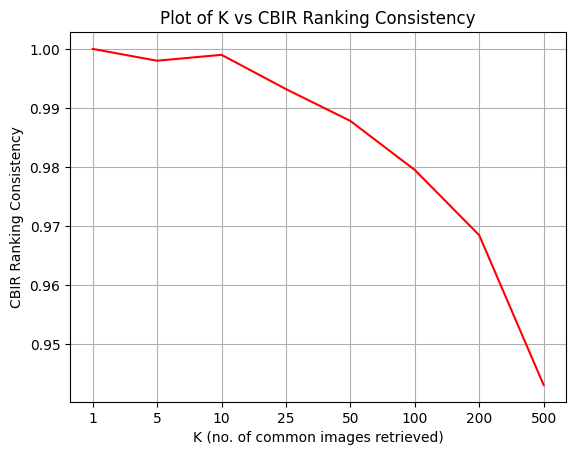

In [36]:
x_positions = list(range(len(K)))
plt.plot(x_positions, cbir_rank_consistencies, linestyle='-', color='r')
plt.xticks(x_positions, K)
plt.xlabel('K (no. of common images retrieved)')
plt.ylabel('CBIR Ranking Consistency')
plt.title('Plot of K vs CBIR Ranking Consistency')
plt.grid(True)
plt.show()